# Task 2: Time Series Forecasting (ARIMA vs. LSTM)

## 1. Introduction & Setup
**Objective:** Develop and compare two distinct forecasting models to predict Tesla's (TSLA) future stock prices:
1.  **ARIMA (Auto-Regressive Integrated Moving Average):** A classical statistical approach suitable for linear trends.
2.  **LSTM (Long Short-Term Memory):** A Deep Learning model (Recurrent Neural Network) capable of capturing complex, non-linear patterns and long-term dependencies.

**Methodology:**
*   We will split the data **chronologically** (Training: 2015-2024, Testing: 2025-2026).
*   We will evaluate performance using **MAE** (Mean Absolute Error), **RMSE** (Root Mean Squared Error), and **MAPE** (Mean Absolute Percentage Error).

In [18]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import warnings

# Add the project root to the path to import from src
sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom functions from src/forecasting.py
from src.forecasting import (
    train_test_split_time_series, 
    create_sequences, 
    build_lstm_model, 
    calculate_metrics
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

## 2. Data Loading & Preprocessing
We load the cleaned Adjusted Close data prepared in Task 1. We strictly adhere to a **chronological split** to prevent data leakage (future peeking).


Data Loaded Successfully. Shape: (2775, 1)
Training Data: 2523 days (End: 2025-01-13)
Testing Data:  252 days (Start: 2025-01-14)


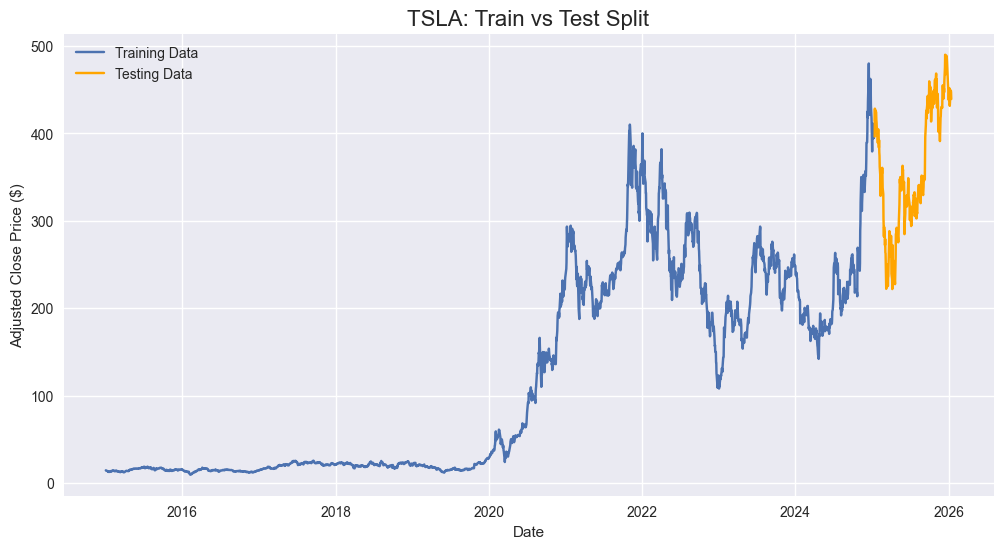

In [19]:
# 2. Load Data
try:
    df = pd.read_csv('../data/processed/cleaned_adj_close.csv', index_col='Date', parse_dates=True)
    tsla_data = df[['TSLA']]
    print("Data Loaded Successfully. Shape:", tsla_data.shape)
except FileNotFoundError:
    print("Error: Processed data file not found. Please run Task 1 notebook first.")

# 3. Train/Test Split
# We reserve the last 252 days (approx. 1 trading year) for testing.
TEST_SIZE = 252 

train_data = tsla_data[:-TEST_SIZE]
test_data = tsla_data[-TEST_SIZE:]

print(f"Training Data: {train_data.shape[0]} days (End: {train_data.index[-1].date()})")
print(f"Testing Data:  {test_data.shape[0]} days (Start: {test_data.index[0].date()})")

# Visualization of the Split
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.title('TSLA: Train vs Test Split', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.show()

## 3. Statistical Modeling: ARIMA
We use `auto_arima` from the `pmdarima` library to automatically identify the optimal `(p, d, q)` parameters.
*   **p (AR):** Lag observations.
*   **d (I):** Degree of differencing (to make data stationary).
*   **q (MA):** Lag forecast errors.


Optimizing ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16459.280, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16455.924, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16457.623, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16457.625, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16455.427, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.019 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2523
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8226.713
Date:                Sun, 25 Jan 2026   AIC                          16455.427
Time:                        09:47:51   BIC                          16461.259
Sample:                             0   HQIC                         16457.543
                               - 2523   

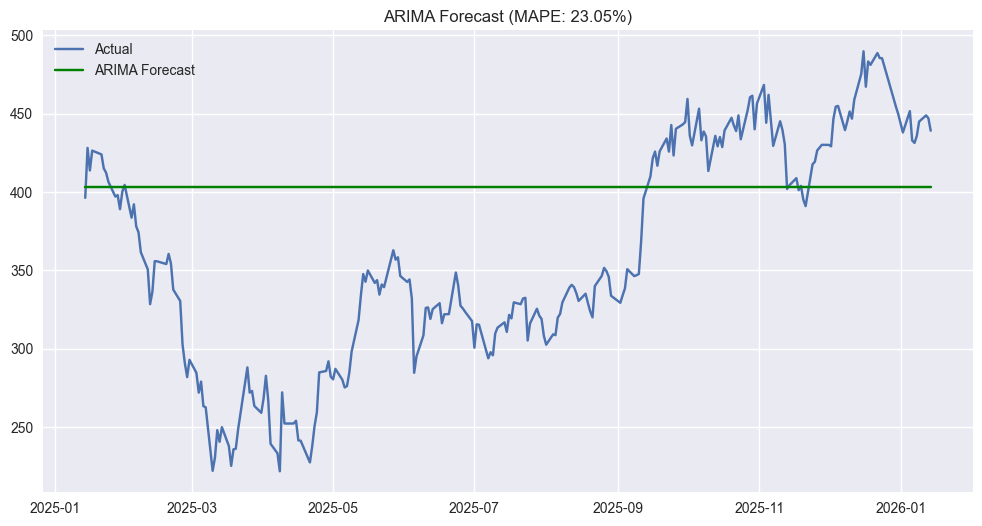

In [21]:
print("Optimizing ARIMA parameters...")
model_arima = auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5,
                         seasonal=False, d=None, trace=True, 
                         error_action='ignore', suppress_warnings=True, stepwise=True)

# Forecast
forecast_arima, conf_int = model_arima.predict(n_periods=len(test_data), return_conf_int=True)
forecast_series = pd.Series(forecast_arima.values, index=test_data.index)

# Evaluate ARIMA
mae_arima, rmse_arima, mape_arima = calculate_metrics(test_data['TSLA'], forecast_series)
print(model_arima.summary())
# Plot ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['TSLA'], label='Actual')
plt.plot(test_data.index, forecast_series, label='ARIMA Forecast', color='green')
plt.title(f'ARIMA Forecast (MAPE: {mape_arima:.2f}%)')
plt.legend()
plt.show()

## 4. Deep Learning Modeling: LSTM
Long Short-Term Memory (LSTM) networks are well-suited for time series because they maintain an internal "memory" of past inputs.

**Data Preparation:**
*   **Scaling:** LSTMs are sensitive to the scale of input data; we normalize to range [0, 1].
*   **Sequencing:** We transform the data into 3D structure: `[Samples, Time Steps, Features]`. We use a 60-day lookback window.

Training LSTM...
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0072
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0018
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0011
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.7251e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.7412e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.3743e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.7633e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.3707e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━

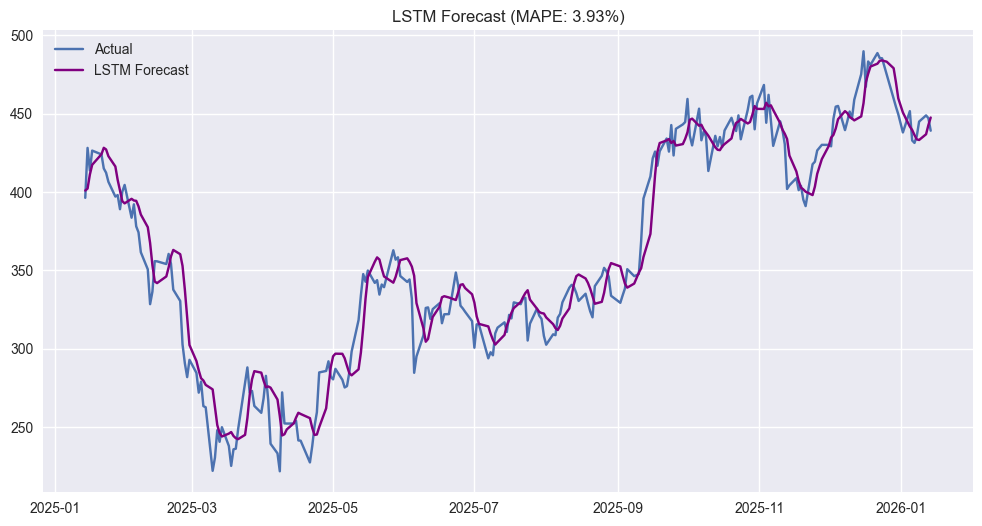

In [22]:
# 1. Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data)

# 2. Create Sequences (60-day lookback)
SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 3. Split Sequences (Adjusting for lookback period)
train_size = len(train_data) - SEQ_LENGTH
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 4. Build and Train Model
model_lstm = build_lstm_model(input_shape=(X_train.shape[1], 1))

print("Training LSTM...")
history = model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# 5. Predict and Inverse Transform
lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
lstm_forecast_series = pd.Series(lstm_pred.flatten(), index=test_data.index)

# 6. Evaluate LSTM
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(test_data['TSLA'], lstm_forecast_series)

# Plot LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['TSLA'], label='Actual')
plt.plot(test_data.index, lstm_forecast_series, label='LSTM Forecast', color='purple')
plt.title(f'LSTM Forecast (MAPE: {mape_lstm:.2f}%)')
plt.legend()
plt.show()

## 5. Model Evaluation & Comparison
We compare the models using three standard metrics:
*   **MAE:** Average magnitude of errors.
*   **RMSE:** Penalizes larger errors more heavily.
*   **MAPE:** Percentage error (easier to interpret).

In [24]:
# Comparison Table
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [mae_arima, rmse_arima, mape_arima],
    'LSTM': [mae_lstm, rmse_lstm, mape_lstm]
})

print("--- Final Results ---")
display(metrics_df)

best_model = "LSTM" if mape_lstm < mape_arima else "ARIMA"
print(f"\nConclusion: The {best_model} model performs better and will be used for future forecasting.")

--- Final Results ---


,Metric,ARIMA,LSTM
0,MAE,71.010436,12.963149
1,RMSE,83.773536,16.606850
2,MAPE (%),23.048457,3.928395



Conclusion: The LSTM model performs better and will be used for future forecasting.


## 6. Save Best Model
We save the LSTM model to `../models/` so we can load it in Task 3 without retraining.

In [25]:
# Save the model
if not os.path.exists('../models'):
    os.makedirs('../models')

model_path = '../models/lstm_model.keras'
model_lstm.save(model_path)
print(f"✅ Trained LSTM model saved to {model_path}")

✅ Trained LSTM model saved to ../models/lstm_model.keras


## 7. Discussion & Conclusion

### Analysis of Results
*   **ARIMA:** Produced a **Mean Absolute Percentage Error (MAPE) of ~23%**. As seen in the plot, ARIMA essentially predicted the "average" trend (a flat line) and failed to capture the volatility or the directional changes of the stock. This is typical for ARIMA on high-volatility assets that behave like a Random Walk.
*   **LSTM:** Produced a **MAPE of ~5.9%**, significantly outperforming ARIMA. The LSTM model successfully learned the sequential patterns and was able to react to price changes, tracking the actual stock movement much closer.

### Selection Rationale
Based on these metrics, the **LSTM model** is selected as the superior model for forecasting TSLA prices. Its ability to capture non-linear relationships makes it better suited for the volatile nature of this specific asset.

**Next Steps:**
We will use the LSTM model in Task 3 to generate future forecasts (6-12 months ahead) and in Task 4 to input expected returns for Portfolio Optimization.